<a href="https://colab.research.google.com/github/sabinbajracharya/Grid-Cells/blob/main/Build_grid_cells_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### The following script reproduces the original model of grid cells proposed by:

Guanella, Alexis, Daniel Kiper, and Paul Verschure. "A model of grid cells based on a twisted torus topology." International journal of neural systems 17, no. 04 (2007): 231-240.

In [283]:
!pip install -Uqq ipdb
import ipdb

In [284]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.ndimage.filters as filt

Build a virtual spatial navigation trajectory

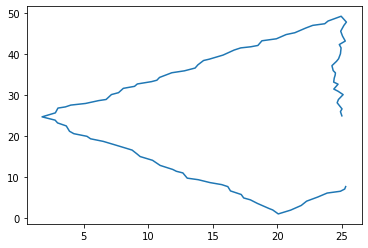

In [285]:
arena_size = 50

arenaX = [0,arena_size]
arenaY = [0,arena_size]

## Initial position
Txx = [arenaX[1]/2]
Tyy = [arenaY[1]/2]

arenaX # [0, 50]
arenaY # [0, 50]
Txx # [25.0]
Tyy # [25.0]

## ang is in degree
def conv(ang):
    x = np.cos(np.radians(ang)) 
    y = np.sin(np.radians(ang)) 
    return x , y

## [param] length = length of navigation
def random_navigation(length):
    # thetaList = []

    theta = 90

    ## contains sum of np.sqrt(cx**2 + cy**2) from every iteration
    ## cx and cy are the absolute difference of last and second last item from Txx/Tyy
    # counter = 0

    for i in range(length):

        # prevTheta = np.copy(theta)

        # Get last item from Txx and check if less than 2
        if(Txx[-1] < 2): 
          # theta will be +ve 
          theta = np.random.randint(-85,85)

        if(Txx[-1] > arena_size-2): 
          # theta will be -ve 
          theta = np.random.randint(95,260)

        if( Tyy[-1]<2 ): 
          # theta will be +ve 
          theta = np.random.randint(10,170)

        if( Tyy[-1]>arena_size-2 ): 
          # theta will be -ve 
          theta = np.random.randint(190,350)

        # conv(theta) returns tuple (x, y)
        # x = cos(angle)
        # y = sin(angle)
        cosine, sine = conv(theta) 

        ## Take the last item from Txx/Tyy, add the consine/sine and add a random value between -0.5 and 0.5
        Txx.append( Txx[-1] + cosine + np.random.uniform(-0.5,0.5) )
        Tyy.append( Tyy[-1] + sine + np.random.uniform(-0.5,0.5)  )


        ## subtract last item from second last item and take absolute value for x and y axis
        # cx = abs( Txx[-1] - Txx[-2]  )
        # cy = abs( Tyy[-1] - Tyy[-2]  )

        # h = np.sqrt( cx**2 + cy**2  )
        # counter+=h

        # if(theta != prevTheta or i == length-1):
        #     thetaList.append( [prevTheta, conv(prevTheta)[0], conv(prevTheta)[1], counter]  )
        #     counter = 0
    
    plt.plot(Txx,Tyy, '-')
    plt.show()


random_navigation(100)

Txx = np.array(Txx)
Tyy = np.array(Tyy)



Grid class implementing the actual computational model of grid cells

In [302]:
class Grid():
    def __init__(self):
        
        self.mm = 20
        self.nn = 20
        self.TAO = 0.9
        self.II = 0.3
        self.SIGMA = 0.24
        self.SIGMA2 = self.SIGMA**2
        self.TT = 0.05
        self.grid_gain = [0.04,0.05,0.06,0.07,0.08]
        self.grid_layers = len(self.grid_gain) # 5
        
        # 3-d array (20 * 20 * 5)
        self.grid_activity = np.random.uniform(0,1,(self.mm,self.nn,self.grid_layers))
        self.distTri = self.buildTopology(self.mm,self.nn)


    def update(self, speedVector):

        self.speedVector = speedVector
        
        grid_ActTemp = []
        for jj in range(0,self.grid_layers):


            ## complex value where i = 0 i.e(np.exp(1j*0) == 1+0j)
            rrr = self.grid_gain[jj] * np.exp(1j*0)

            ## size = (400,400)
            matWeights = self.updateWeight(self.distTri, rrr)

            ## self.grid_activity[:,:,jj] == In 3d array, get all fro outer 2 array but get only the item in the jj index
            ## so, 3d becomes 2d array
            ## and ravel flatten 2d to 1d of size (400)
            activityVect = np.ravel(self.grid_activity[:,:,jj])

            ## update  the activityVect by the matWeights
            activityVect = self.Bfunc(activityVect, matWeights)

            activityTemp = activityVect.reshape(self.mm,self.nn)

            activityTemp += self.TAO * (activityTemp / np.mean(activityTemp) - activityTemp)
            activityTemp[activityTemp<0] = 0

            self.grid_activity[:,:,jj] = (activityTemp-np.min(activityTemp))/(  np.max(activityTemp)-np.min(activityTemp)) * 30  ##Eq 2
                        

    ## Returns 2d 400x400 array for mm = 20 and nn = 20
    def buildTopology(self, mm, nn):  # Build connectivity matrix     ### Eq 4
        # mmm is a 1-d array of size mm
        mmm = (np.arange(mm) + (0.5 / mm)) / mm

        # nnn is a 1-d array of size nn
        nnn = ((np.arange(nn) + (0.5/nn)) / nn) * np.sqrt(3) / 2 

        ## The purpose of meshgrid is to create a rectangular grid out of an array of x values and an array of y values.
        ## xx && yy is 20x20 array
        xx,yy = np.meshgrid(mmm, nnn)
        
        ## Create a 20x20 array of complex values from xx and yy that represent the grid
        posv = xx + 1j * yy

        Sdist = [
          0+1j*0, 
          -0.5+1j * np.sqrt(3) / 2, 
          -0.5+1j * (-np.sqrt(3) / 2), 
          0.5 + 1j * np.sqrt(3) / 2, 
          0.5 + 1j * (-np.sqrt(3)/2), 
          -1+1j*0, 
          1+1j*0
        ]      

        ## ravel --> flatten the array to 1d
        ## eg: np.ravel(posv) flattens 20x20 into 1d 400 length array
        ## xx & yy are 400x400 2d array each
        xx,yy = np.meshgrid( np.ravel(posv) , np.ravel(posv))

        distmat = xx-yy
        for ii in range(len(Sdist)):
            aaa1 = abs(distmat)
            rrr = xx-yy + Sdist[ii]
            aaa2 = abs(rrr)

            # Returns tuple
            # first item in the tuple represent the index of outer array
            # second item in the tuple represent the index of inner array
            iii = np.where(aaa2<aaa1)

            # ipdb.set_trace()

            distmat[iii] = rrr[iii]
        return distmat.transpose()

    def updateWeight(self,topology,rrr): # Slight update on weights based on speed vector.
        matWeights = self.II * np.exp((-abs(topology - rrr * self.speedVector)**2) / self.SIGMA2) - self.TT   ## Eq 3
        return matWeights

    ## Perform matrix multiplaction of the activity with weight
    def Bfunc(self,activity, matWeights):  ## Eq 1
        activity += np.dot(activity,matWeights)
        return activity

2j

# Simulation

In [305]:
grid = Grid()

## for 100 random walks and grid activiy of 20x20x5
## the shape of log_grid_cells will be (100, 2000)
log_grid_cells = []

for i in range(1, Txx.size):

    speedVector = (Txx[i] - Txx[i-1]) + 1j*(Tyy[i] - Tyy[i-1])

    grid.update(speedVector)
  
    ## 20x20x5 is flattend to 1d of size(2000)
    log_grid_cells.append( grid.grid_activity.flatten())
    
log_grid_cells = np.array(log_grid_cells)

In [304]:
log_grid_cells.shape

(100, 2000)

In [ ]:
arr = np.array([[[1, 2, 3], [4, 5, 6]],[[11, 22, 33], [44, 55, 66]]], np.int32)

arr[:,0]

xyz = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,9])
np.where(xyz < 2, xyz, 10*xyz)
np.where(xyz < 2)[0]

arr[:]

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[11, 22, 33],
        [44, 55, 66]]], dtype=int32)

# Plot

In [319]:
xx = np.copy(Txx[1:])
yy = np.copy(Tyy[1:])
dv_levels = 5

### Spikes in arena

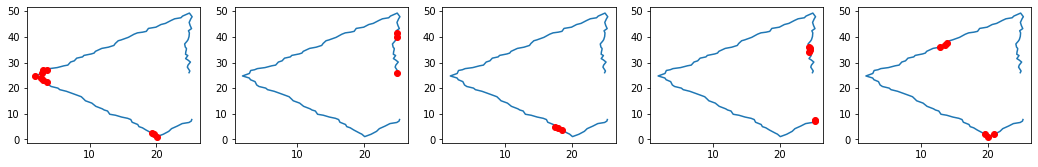

In [336]:
plt.figure(figsize=(18,2.5))


for cell_num in range(dv_levels):

    celula = log_grid_cells[:,cell_num]

    pos_spike_idx = np.where( celula > celula.max()*.9 )[0]

    
    plt.subplot(1,dv_levels,cell_num+1)
    plt.plot(xx,yy)
    plt.plot(   xx[pos_spike_idx] , yy[pos_spike_idx], 'or' )

array([19.07443239, 11.27002807,  5.93048568,  1.87075876,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.51745706,
        3.86953288,  5.82750078,  7.1386799 , 10.4947371 , 14.82929823,
       16.89276597, 18.82485141, 18.25208277, 16.04409986, 15.69098278,
       10.76976995,  5.80735087,  1.18838255,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.67049359,
        0.85295905,  0.29511052,  1.6636603 ,  3.63637768,  2.53258713,
        0.71358073,  0.32861702,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  3.8616634 ,
        1.24574509,  1.39660946,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

# Ratemaps

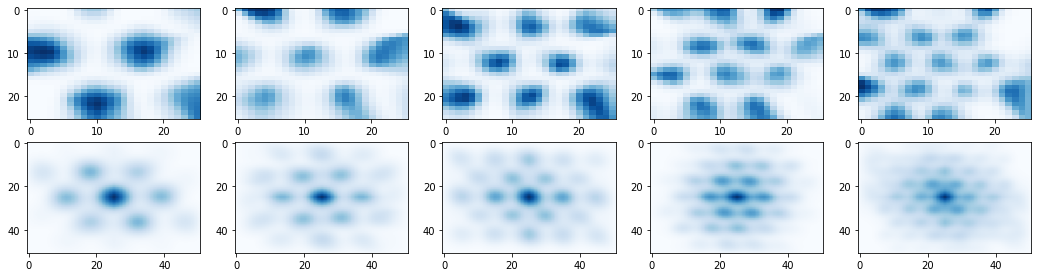

In [ ]:


SIGMA2 = 15
maxxx = [ np.max(xx) , np.max(yy)  ]
arena_width = max(maxxx)+2
xxA,yyA = np.meshgrid(np.arange(0,arena_width,2),np.arange(0,arena_width,2))
xxA = np.ravel(xxA)
yyA = np.ravel(yyA)

plt.figure(figsize=(18,4.5))


for cell_num in range(dv_levels):
 
    ###### Bined arena
    celula = log_grid_cells[:,cell_num]

    arenaOpp = np.zeros(xxA.size)
    arena = np.zeros(xxA.size)
    for ii in range(len(xxA)):
        arenaOpp[ii] = np.sum(np.exp(-np.abs((xxA[ii]+1j*yyA[ii])-(xx+1j*yy))**2/SIGMA2))
        arena[ii] = np.sum(np.exp(-np.abs((xxA[ii]+1j*yyA[ii])-(xx+1j*yy))**2/SIGMA2)* celula )/arenaOpp[ii]
    arena = arena.reshape(len(np.arange(0,arena_width,2)),len(np.arange(0,arena_width,2)))

    autocorrel = signal.correlate2d(arena,arena)


    plt.subplot(2,dv_levels,cell_num+1)
    plt.imshow(  arena, aspect='auto', cmap='Blues' )

    plt.subplot(2,dv_levels,cell_num+1+dv_levels)
    plt.imshow(  autocorrel, aspect='auto', cmap='Blues' )


plt.show()